# Pregunta 6

(2 puntos) La imagen Ex3Preg6(a).tif muestra una imagen tomada con un microscopio de cultivo de bacterias identificadas por los círculos intensos:

a. (0.5 puntos) Usando una técnica de umbralización global, segmente la imagen y muestre el resultado de la segmetnación.

b. (0.5 puntos) A la imagenoriginal se le aplicó una umbralización con valores locales yal resultado se le realizó una apertura morbológica obteniendo la imagen Ex3Preg6(b).tif. Usando esta imagen,cuente y etiquete cuantos objetos de la segmentación pueden considerarse células independientes. 

c. (1 punto) Continuando con la imagen anterior. Cuente y etiquete cuantos objetos de la segmentación pueden considerarse 2 células agrupadas, y cuantos y cuales más de 2 células.

In [148]:
# Annotations
from typing import Tuple, List, Callable, NoReturn, Any, Optional

# Functional programing tools : 
from functools import partial, reduce
from itertools import chain

# Visualisation : 
import matplotlib.pyplot as plt
import matplotlib.image as pim
import matplotlib.patches as mpatches
import seaborn as sns

# Data tools :
import numpy as np
import pandas as pd

# Image processing : 
import cv2 as cv
from scipy import ndimage as ndi
import skimage
from skimage import data
import skimage.segmentation as seg
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.morphology import watershed
from skimage.feature import peak_local_max


# Machine Learning :
from sklearn.cluster import KMeans

# Jupyter reimport utils :
import importlib

In [2]:
# Custom :
import mfilt_funcs as mfs
importlib.reload(mfs)
import mfilt_funcs as mfs

import utils
importlib.reload(utils)
import utils

In [75]:
# Being lazy :
lmap = lambda x, y: list(map(x, y))
lfilter = lambda x, y: list(filter(x, y))

In [243]:
def segplot(
    img: np.ndarray, 
    group: skimage.measure._regionprops.RegionProperties, 
    color: Optional[str] = None,
    title: Optional[str] = None
) -> NoReturn:
    """
    """
    if not color:
        color = 'red'
        
    fig, ax = plt.subplots(figsize=(9, 9))
    ax.imshow(imgb2c, cmap='gray')

    for region in group:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)
    
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()
##

def image_show(image, nrows=1, ncols=1, cmap='gray', **kwargs):
    """
        Taken from :
        https://github.com/gmagannaDevelop/skimage-tutorials/blob/master/lectures/4_segmentation.ipynb
    """
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax
##

def watershed_viz(image, distance, labels):
    """
        Constructed from the example found in :
        https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html
    """
    fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Overlapping objects')
    ax[1].imshow(-distance, cmap=plt.cm.gray)
    ax[1].set_title('Distances')
    ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
    ax[2].set_title('Separated objects')

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
##

def ez_watershed(image: np.ndarray, footprint: Optional[np.array] = None, **kw) -> Tuple[int, int, int]:
    """
    """
    distance = ndi.distance_transform_edt(image)
    if footprint is not None:
        fp = footprint
    else:
        fp = np.ones((10, 10))
    local_maxi = peak_local_max(
        distance, 
        indices=False, 
        footprint=np.ones((10, 10)),
        labels=image,
        **kw
    )
    markers = ndi.label(local_maxi)[0]
    labels  = watershed(-distance, markers, mask=image)
    
    return markers, distance, labels
##

In [3]:
#plt.style.available

In [4]:
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (10, 5)

In [5]:
img   = cv.imread('imagenes/Ex3Preg6(a).tif', cv.IMREAD_GRAYSCALE)
color = cv.cvtColor(img, cv.COLOR_GRAY2RGB) # Color copy, to draw colored circles

## a. (0.5 puntos) Usando una técnica de umbralización global, segmente la imagen y muestre el resultado de la segmetnación.

In [6]:
intensities = pd.core.frame.DataFrame(dict(intensity=img.flatten()))

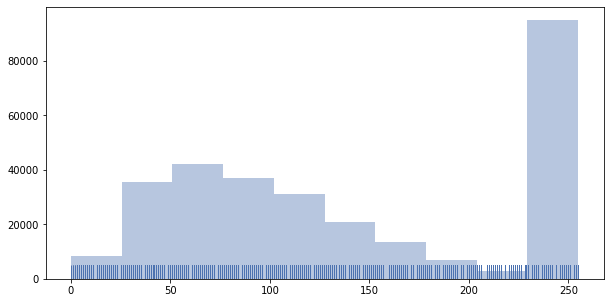

In [7]:
sns.distplot(intensities, kde=False, rug=True, bins=10)

In [69]:
kmeans = KMeans(n_clusters=2, random_state=0, verbose=False).fit(intensities)
K = int(kmeans.cluster_centers_.mean())

In [154]:
centers1 = lmap(int, list(chain.from_iterable(kmeans.cluster_centers_)))

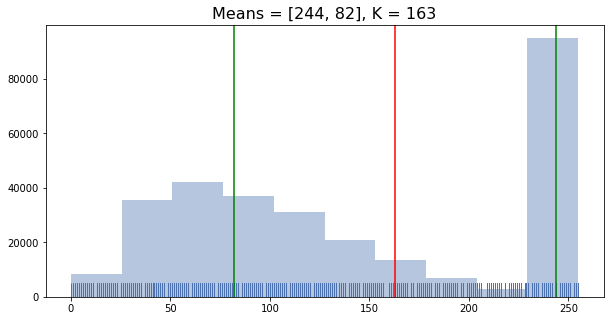

In [74]:
sns.distplot(intensities, kde=False, rug=True, bins=10)
plt.axvline(K, color='r')
lmap(lambda x: plt.axvline(x, color='g'), centers1)
_ = plt.title(f"Means = {centers1}, K = {K}", size=16)

In [10]:
thresh1 = cv.threshold(img, K, 255, cv.THRESH_BINARY)[1]

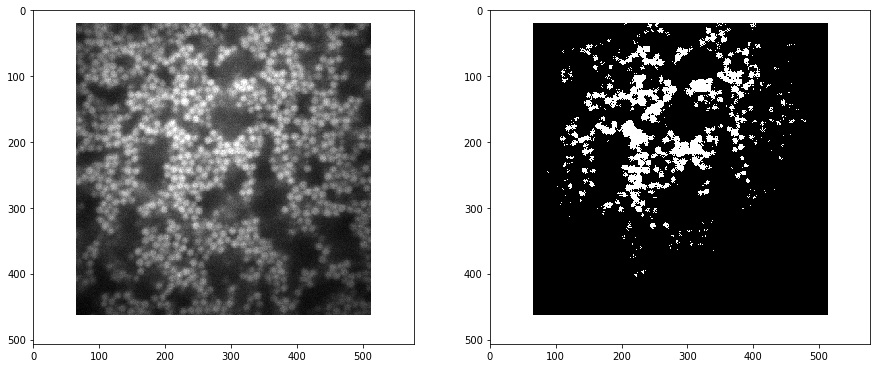

In [11]:
utils.side_by_side(img, thresh1)

Como podemos ver, una técinca de umbralización estándar como k-medias móviles, con dos medias, da resultados muy pobres.

In [12]:
otsu1 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)[1]

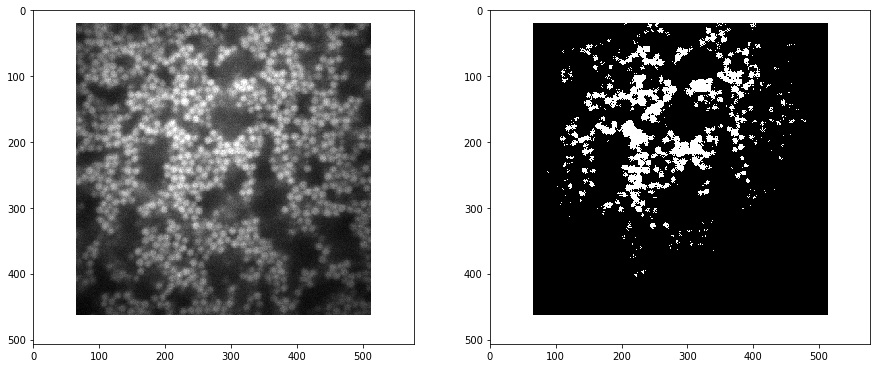

In [13]:
utils.side_by_side(img, otsu1)

El algoritmo de Otsu no logra mejorar mucho la segmentación (esto era de esperarse dado que el histograma original era claramente bimodal). 

In [14]:
gblur = cv.GaussianBlur(img,(3,3),0)
otsu2 = cv.threshold(gblur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)[1]

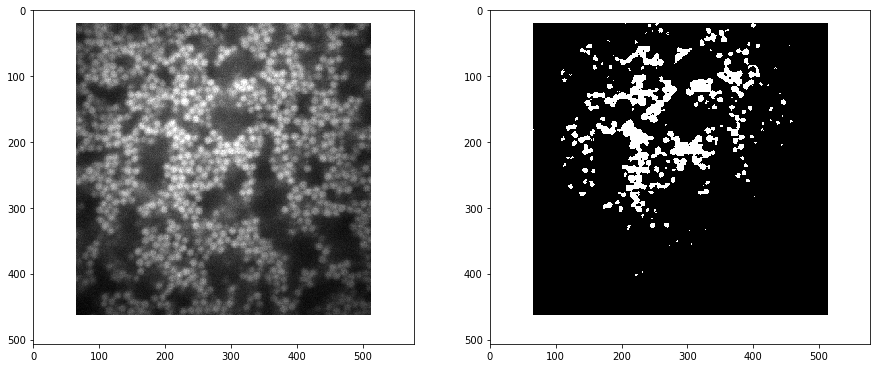

In [15]:
utils.side_by_side(img, otsu2)

El algoritmo de Otsu no logra mejorar mucho la segmentación aún en combinación con un suavizado Gaussiano.

In [16]:
img_blur = cv.medianBlur(img, 5)
circles = cv.HoughCircles(img_blur, cv.HOUGH_GRADIENT, 1, img.shape[0]/64, param1=200, param2=10, minRadius=5, maxRadius=7)

In [17]:
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv.circle(img, (i[0], i[1]), i[2], (0, 0, 255), 2)

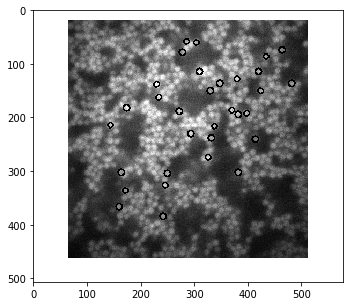

In [18]:
plt.imshow(img, cmap='gray')

Al ver que las células tenían una apariencia más o menos circular, parecía una buena idea usar una transformada de Hough para buscar los círculos de la imagen, pero esto entregó resultados muy pobres. Tal vez esto podría funcionar con la imagen binaria.

## b. (0.5 puntos) A la imagenoriginal se le aplicó una umbralización con valores locales yal resultado se le realizó una apertura morbológica obteniendo la imagen Ex3Preg6(b).tif. Usando esta imagen,cuente y etiquete cuantos objetos de la segmentación pueden considerarse células independientes. 

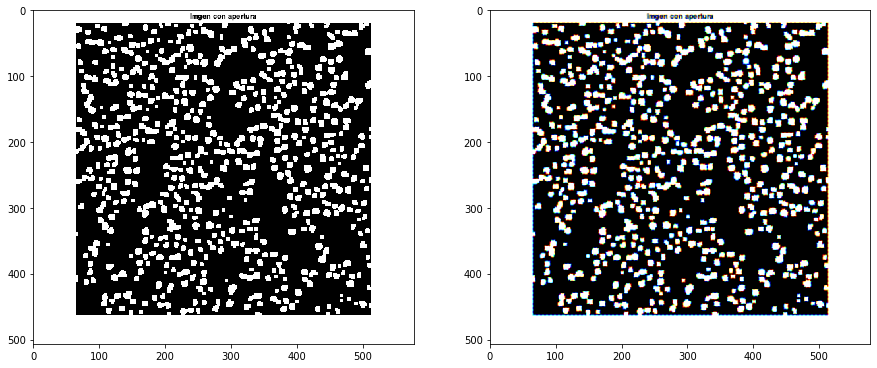

In [19]:
imgb  = cv.imread('imagenes/Ex3Preg6(b).tif', cv.IMREAD_GRAYSCALE)
imgbc = cv.cvtColor(imgb, cv.COLOR_BAYER_GB2RGB)
utils.side_by_side(imgb, imgbc)

### Primera aproximación :
El uso de la transformada de Hough para círculos, no para líneas. Al ver la imagen, uno podría pensar que un círculo es una buena aproximación de la forma de una célula, por lo tanto los cículos encontrados por una transformada de Hough serían las células que buscamos identificar, caracterizar y contabilizar

In [20]:
circles = cv.HoughCircles(imgb, cv.HOUGH_GRADIENT, 1, img.shape[0]/64, param1=200, param2=10, minRadius=5, maxRadius=15)

In [21]:
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv.circle(imgbc, (i[0], i[1]), i[2], (155, 0, 0), 2)

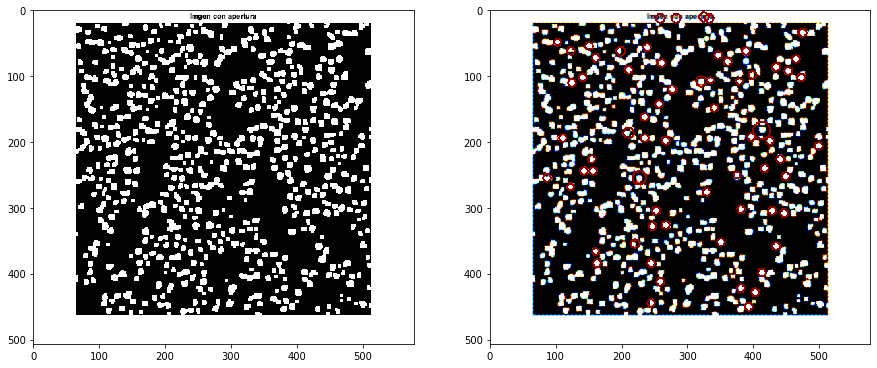

In [22]:
utils.side_by_side(imgb, imgbc)

Aquí podemos ver que aunque la imagen principal carece de falsos positivos (es decir todos los círculos dibujados dentro de la región útil de la imagen contienen una célula) el **número de falsos negativos es altísimo** : sólo una pequeña parte de las células observadas fueron identificadas por ```cv.HoughCircles()```. 

Esto nos indica que tal vez las células no se asemejan tanto a un círculo. Por esta razón, no se explorará más a fondo esta vía de acción. Cabe mencionar que la transformada encuentra círculos en el texto de encabezado : **Imagen con apertura**. Por esta razón, en delante se trabajará con otra imagen recortada a mano para excluir este texto que podría causar problemas en la segmentación más adelante.

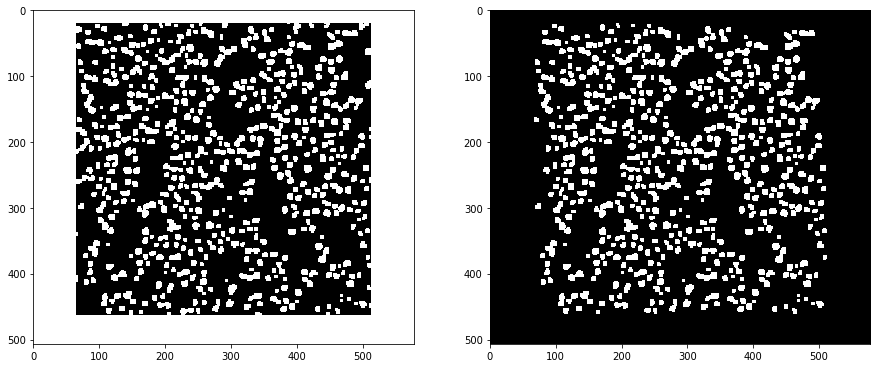

In [23]:
imgb2  = cv.imread('imagenes/Ex3Preg6(b)3.tif', cv.IMREAD_GRAYSCALE)
imgb2c = clear_border(imgb2)
utils.side_by_side(imgb2, imgb2c)

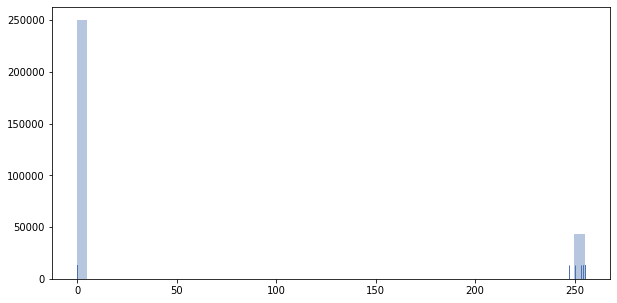

In [24]:
sns.distplot(imgb2c.flatten(), kde=False, rug=True)

Imagen claramente binaria.

474


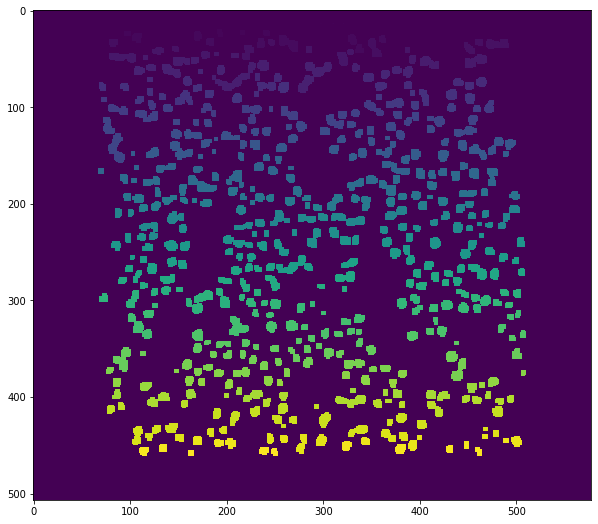

In [25]:
label_image, n_objs = label(imgb2c, return_num=True)
fig, ax = plt.subplots(figsize=(10, 10))
#ax.imshow(label_image[100:200,0:100:])
ax.imshow(label_image)
print(n_objs)

Aquí podemos ver cómo ```skimage.label()``` es efectivo para identificar objetos en una imagen binaria.

In [26]:
objs = regionprops(label_image) 
areas = pd.core.frame.DataFrame({
    'area': map(lambda x: x.area, objs)
})

Bajo las hipótesis :
    1. El área observable de las bacterias sigue una distribución normal razonablemnte estrecha.
    2. El área de la máscara de segmentación generada a través de una umbralización con valores locales y una apertura morfológica es una buena aproximación del área de una célula.

La conclusión lógica sería que donde se tenían dos o más células y que la apertura unió las regiones de segmentación, el valor del área aumentará consecuentemente.

(             area
 count  474.000000
 mean    90.411392
 std     59.468520
 min      1.000000
 25%     55.250000
 50%     76.000000
 75%    104.000000
 max    455.000000, <matplotlib.axes._subplots.AxesSubplot at 0x1c2c6ebd90>)

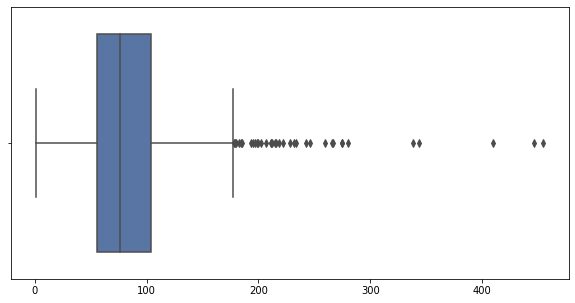

In [28]:
areas.describe(), sns.boxplot(areas)

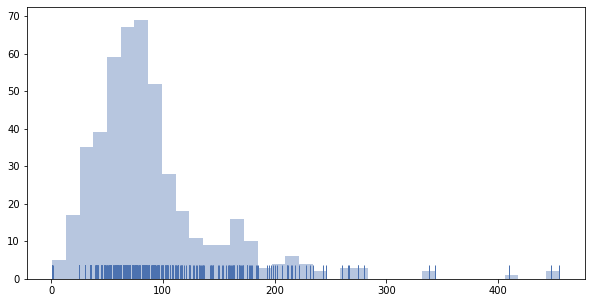

In [30]:
sns.distplot(areas, kde=False, rug=True)

Analizando la distribución de las áreas, se encuentran algunos puntos cercanos a cero, éstos serán inspeccionados a continuación.

In [41]:
_ = areas.area.sort_values()
_[:10], _[-10:]

(0       1
 2       1
 3       1
 4       1
 1       2
 241    25
 226    25
 29     25
 199    25
 33     25
 Name: area, dtype: int64, 362    266
 166    267
 416    275
 329    275
 219    280
 306    338
 263    344
 39     410
 98     447
 40     455
 Name: area, dtype: int64)

Algunos de los primeros valores de las áreas corresponden claramente a falsos positivos, porque no tenemos células de uno o dos pixeles. Estos pixeles blancos no se observaban en la imagen original, de cualquier manera se retirarán manualmente para no sesgar el análisis posterior.

Se propone clasificar los cúmulos de 1, 2 y 3 o más bacterias en función del área. Se utilizará el algoritmo de las medias móviles con tres grupos, es decir dos umbrales.

In [44]:
objs2  = regionprops(label_image)
objs2  = list(filter(lambda x: x if x.area > 2 else False, objs2))
areas2 = pd.core.frame.DataFrame({
    'area': map(lambda x: x.area, objs2)
})

In [98]:
kmeans2 = KMeans(n_clusters=3, random_state=0, verbose=False).fit(areas2)
centers = pd.core.frame.DataFrame({
    "means": chain.from_iterable(kmeans2.cluster_centers_)
})
centers['k'] = centers.rolling(2).mean()
print(centers)
centers = centers.applymap(lambda x: np.int64(x) if not np.isnan(x) else x)
print(centers)

        means           k
0   68.559367         NaN
1  167.696203  118.127785
2  328.818182  248.257192
   means      k
0     68    NaN
1    167  118.0
2    328  248.0


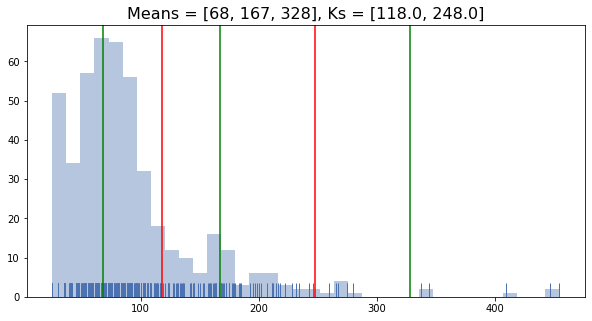

In [146]:
sns.distplot(areas2, kde=False, rug=True)
lmap(lambda x: plt.axvline(x, color='r'), centers.k.dropna())
lmap(lambda x: plt.axvline(x, color='g'), centers.means)
_ = plt.title(f"Means = {centers.means.tolist()}, Ks = {centers.k.dropna().tolist()}", size=16)

In [100]:
ks = centers.k.dropna().tolist()
cells = [
    lfilter(lambda x: x if x.area < ks[0] else False, objs2),
    lfilter(lambda x: x if x.area >= ks[0]  and x.area < ks[1] else False, objs2),
    lfilter(lambda x: x if x.area >= ks[1] else False, objs2)
]

Creamos una lista de listas en la cual están contenidos tres grupos de bacterias (cúmulos de 1, 2 o más) identificados por ```skimage.label()```, separados en función de los umbrales encontrados promediando los promedios encontrados por ```sklean.KMeans()```.

A continuación se observan las máscaras identificando los grupos respectivos. Nótese que el conjunto con la mayor cantidad de errores (sobre todo falsos positivos) es el de dos células.

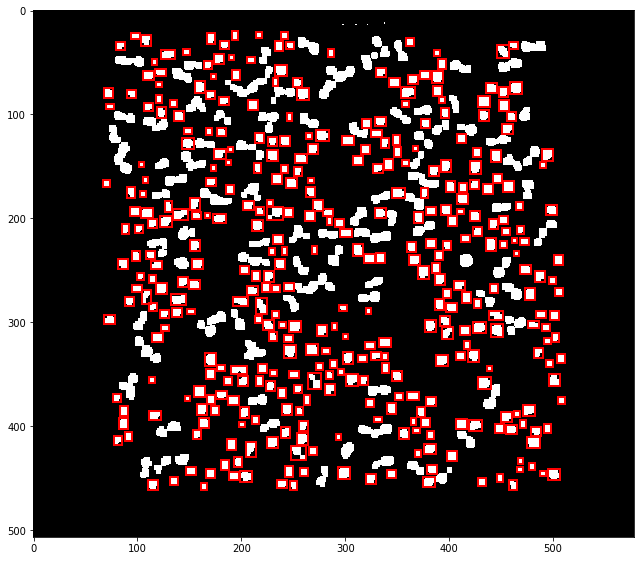

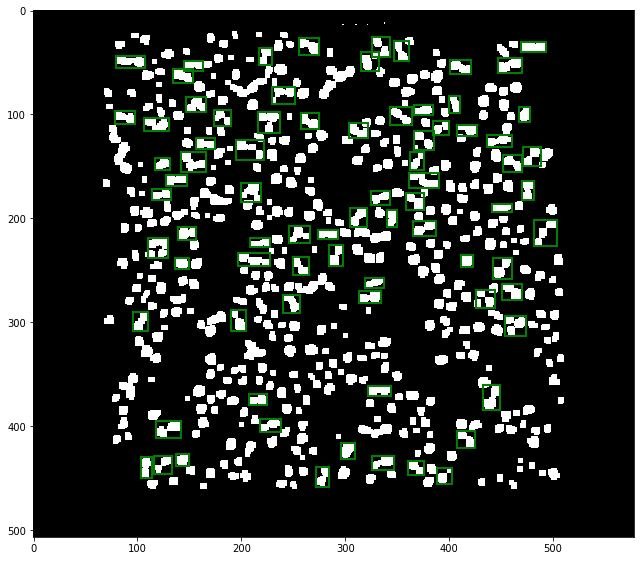

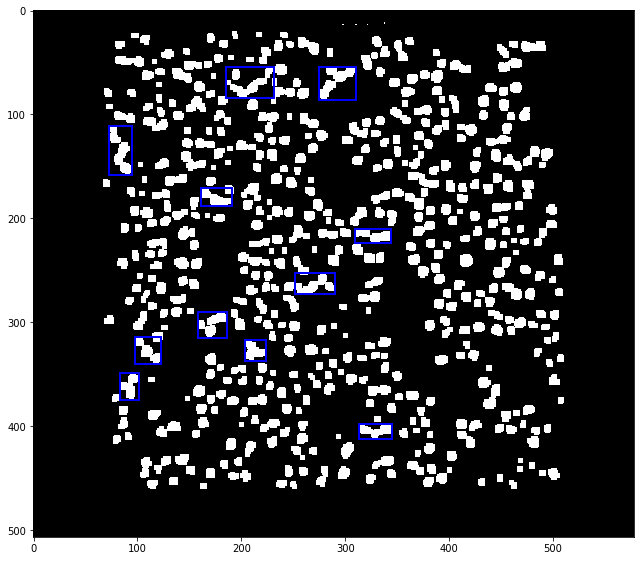

In [135]:
for cell, color in zip(cells, 'red green blue'.split(' ')):
    segplot(imgb2c, cell, color=color)

In [142]:
conteo = {f"Objetos de {i} células": len(cells[i-1]) for i in range(1, 4)}
conteo

{'Objetos de 1 células': 379,
 'Objetos de 2 células': 79,
 'Objetos de 3 células': 11}

In [165]:
plt.close('all')

In [262]:
"""
for cell in cells[2]:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(cell.image, cmap='gray')
"""

"\nfor cell in cells[2]:\n    fig, ax = plt.subplots(figsize=(10, 10))\n    ax.imshow(cell.image, cmap='gray')\n"

In [187]:
pad = lambda x: cv.copyMakeBorder(np.float64(x.image), 10, 10, 10, 10, cv.BORDER_CONSTANT)

In [265]:
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
"""
image = pad(cells[1][-3])
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(
    distance, 
    indices=False, 
    footprint=np.ones((10, 10)),
    labels=image
)
markers = ndi.label(local_maxi)[0]
labels  = watershed(-distance, markers, mask=image)
"""

'\nimage = pad(cells[1][-3])\ndistance = ndi.distance_transform_edt(image)\nlocal_maxi = peak_local_max(\n    distance, \n    indices=False, \n    footprint=np.ones((10, 10)),\n    labels=image\n)\nmarkers = ndi.label(local_maxi)[0]\nlabels  = watershed(-distance, markers, mask=image)\n'

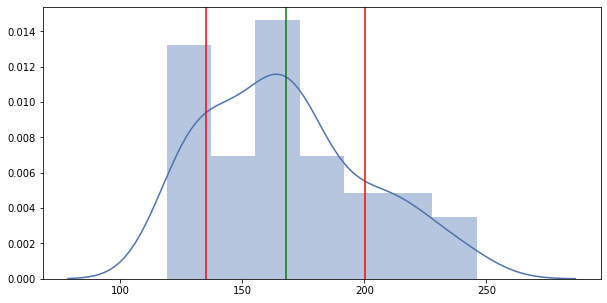

In [274]:
areas2 = pd.core.series.Series(lmap(lambda x: x.area, cells[1]))
sns.distplot(areas2)
plt.axvline(areas2.mean(), color='g')
plt.axvline(areas2.mean() + areas2.std() , color='r')
plt.axvline(areas2.mean() - areas2.std() , color='r')

In [275]:
grandes = [cell for cell in cells[1] if cell.area < areas2.mean() - 0.5*areas2.std()]

In [285]:
cells[1][2].area

163

In [286]:
propiedades2 = pd.core.frame.DataFrame({
    "A * P": lmap(lambda x: x.area * x.perimeter, cells[1]),
    "A / P": lmap(lambda x: x.area / x.perimeter, cells[1]),
    "P / A": lmap(lambda x: x.perimeter / x.area, cells[1]),
    "convex A": lmap(lambda x: x.convex_area, cells[1])
})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c325e97d0>,
      dtype=object)

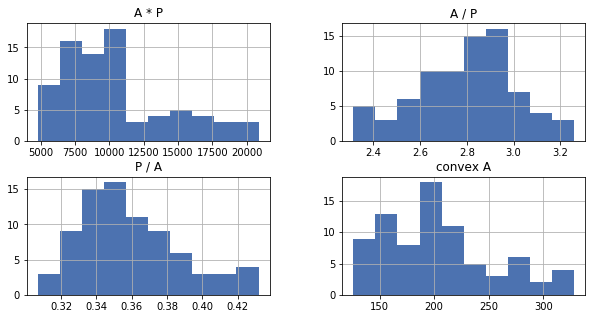

In [287]:
propiedades2.hist()

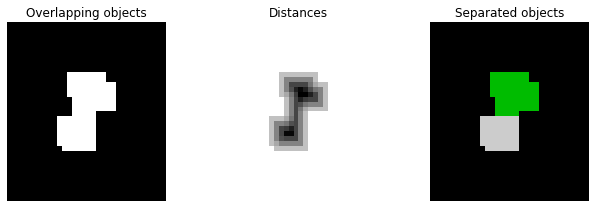

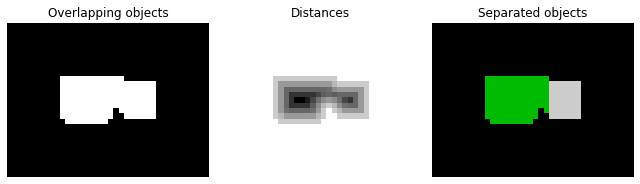

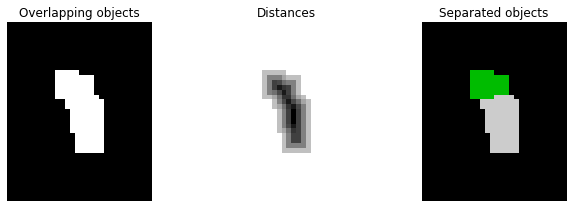

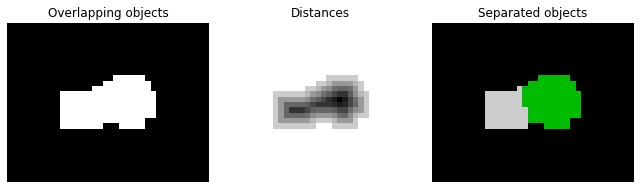

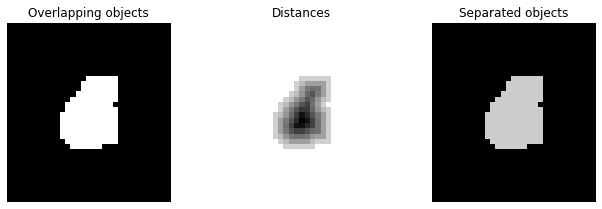

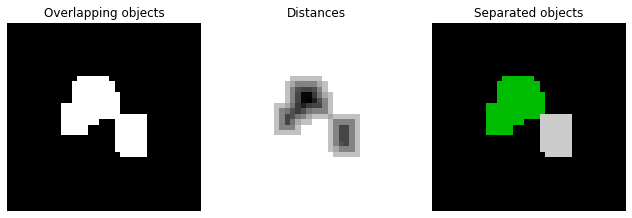

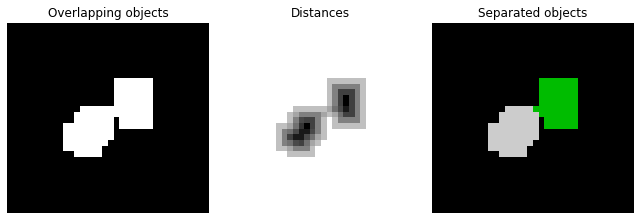

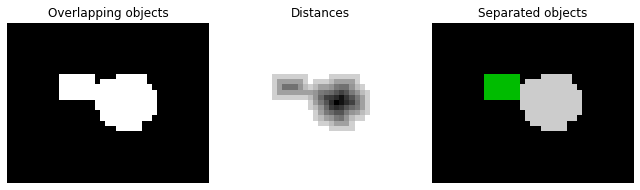

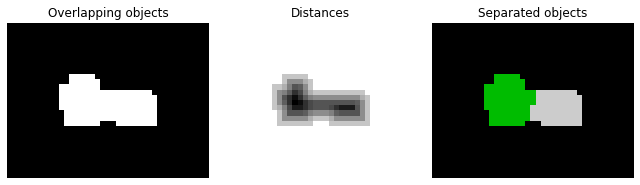

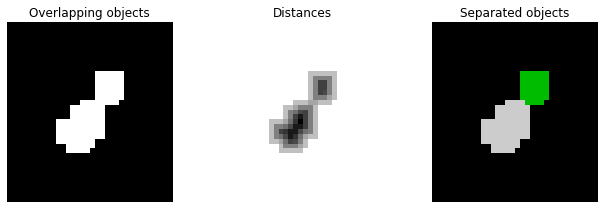

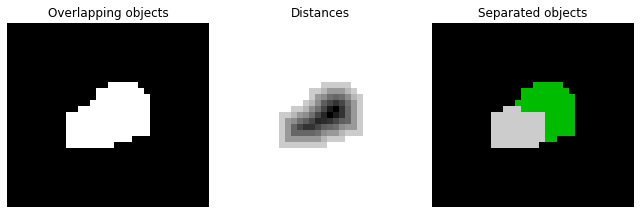

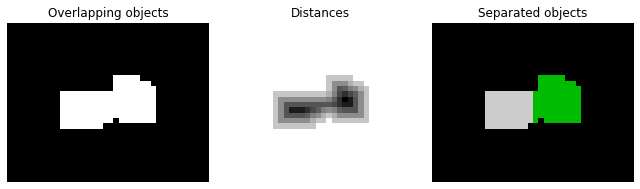

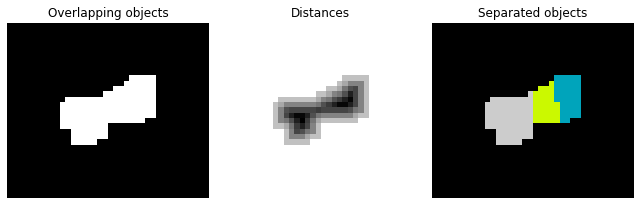

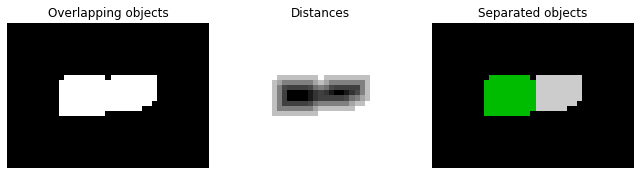

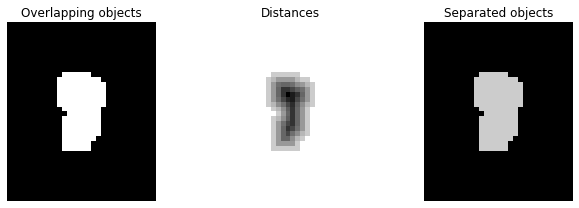

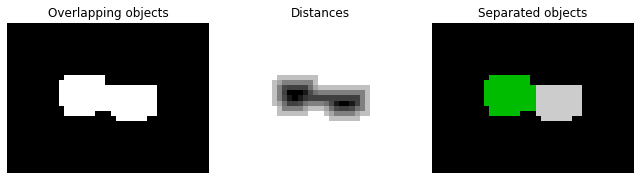

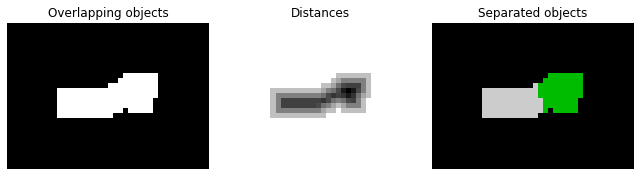

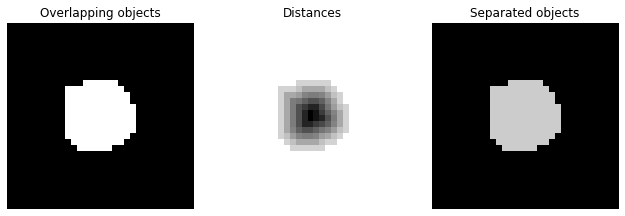

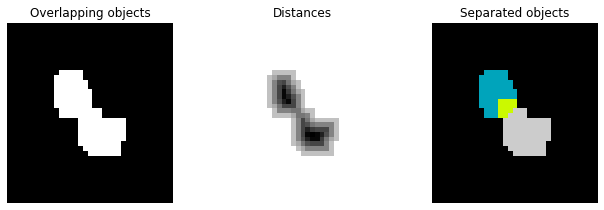

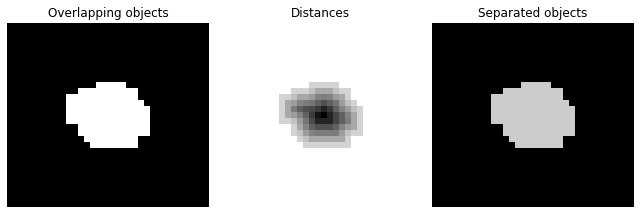

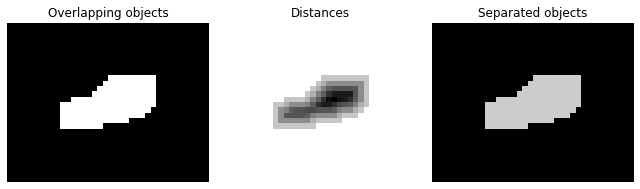

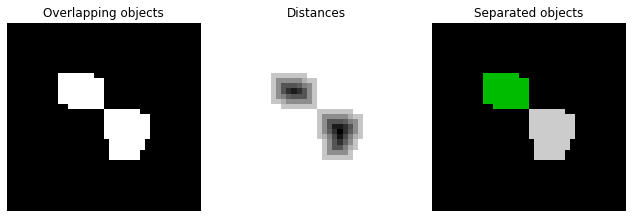

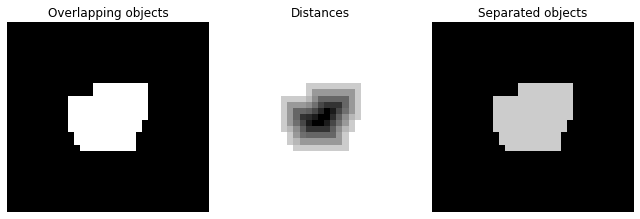

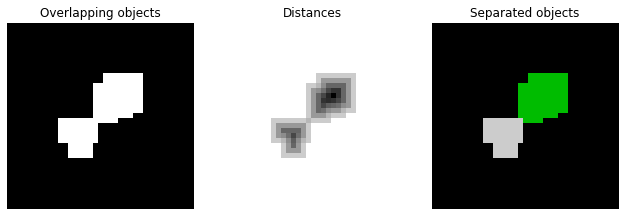

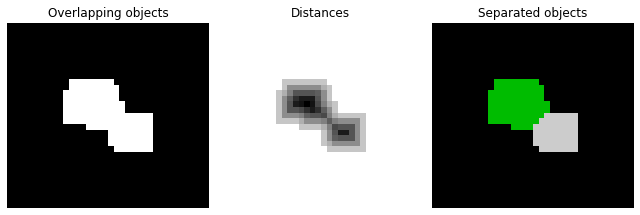

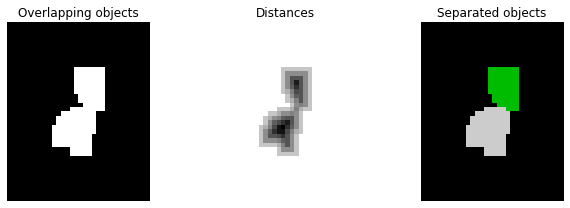

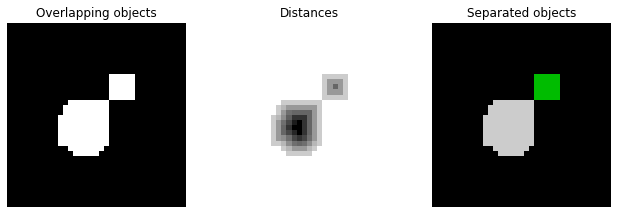

In [277]:
for cell in grandes:
    image = pad(cell)
    markers, distance, labels = ez_watershed(image, footprint=np.ones((5, 5)))
    watershed_viz(image, distance, labels)

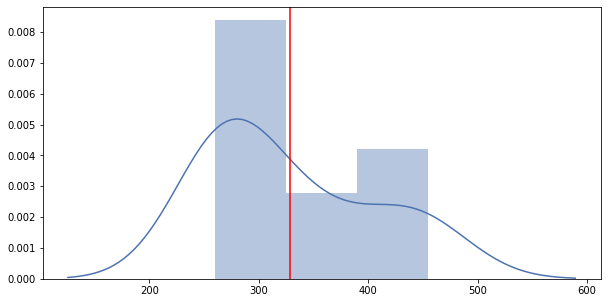

In [247]:
areas3 = lmap(lambda x: x.area, cells[2])
mean_area3 = np.mean(areas3)
sns.distplot(areas3)
plt.axvline(mean_area3, color='r')

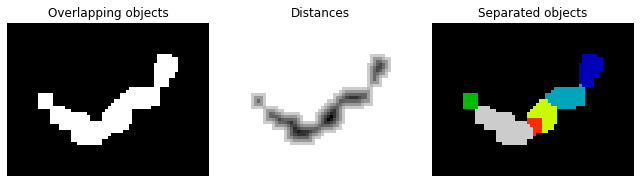

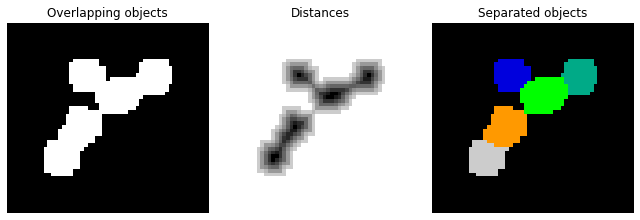

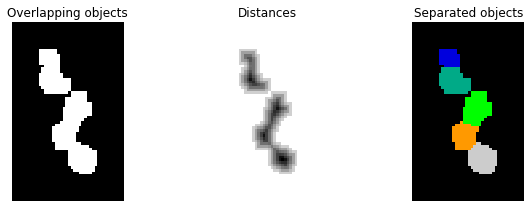

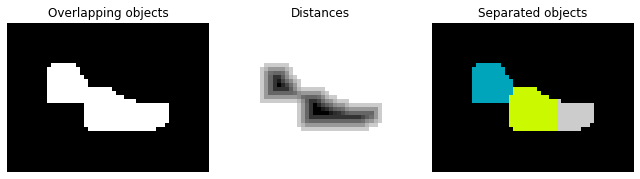

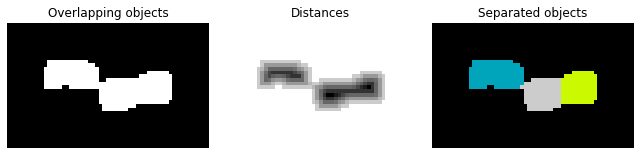

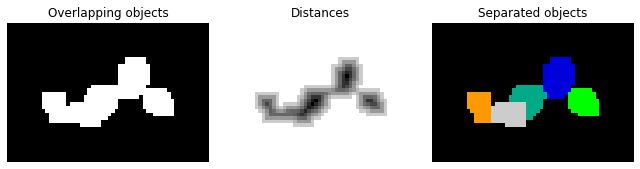

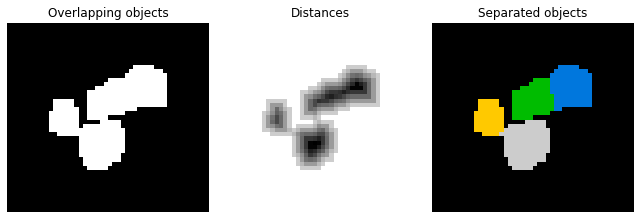

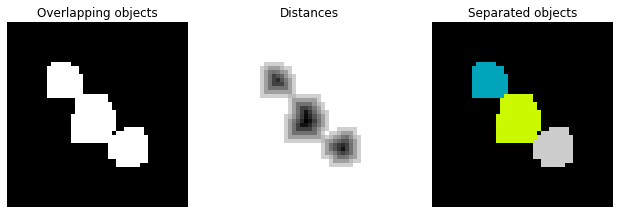

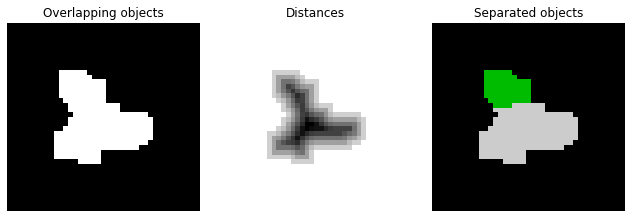

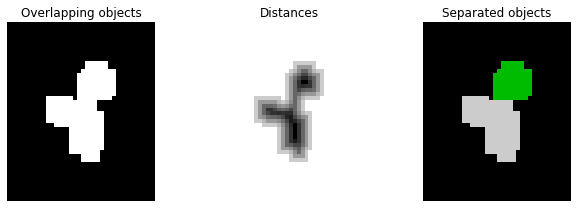

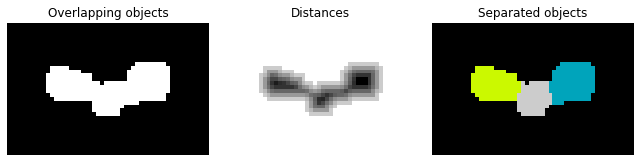

In [229]:
for cell in cells[2]:
    image = pad(cell)
    markers, distance, labels = ez_watershed(image)
    watershed_viz(image, distance, labels)

In [261]:
markers, distance, labels = ez_watershed(cells[1][-6].image, footprint=np.ones((5, 5)))
markers

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,